#   **22 October 2025**

In [142]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize

- [ ] Create plots that compare the results for fitting the BW and Gaussian distributions to the given dataset based on 
    - [X] using SciPy's curve fitting,
    - [ ] ~~using your implementation of gradient descent,~~ and
    - [ ] using `optimize.minimize` with at least two different methods. 
- [ ] Compare how the results differ, then 
    - [ ] discuss how the approaches differ, 
    - [ ] how fast they converge, 
    - [ ] how sensitive it is to the choice of x0, etc. 
- [ ] ~~Include the code for your gradient descent implementation and how you used it for curve fitting.~~

#   Lab Activity

- [ ] Implement gradient descent as listed in Ch. 5.6 of Gezerlis (see Code 5.7), but the scalar function is the cost function (chi-squared) as described above.
- [ ] Use different optimizers available in Scipy. Check how accurate their results are and how fast (iteration/evaluation count) they converge to a solution, if at all. Note how the methods differ with each other

#   Gradient Descent

Recall that the "fixed-step-by-step" solution is given by

$$\vec{x}^{(k)} = \vec{x}^{(k-1)} - \gamma\vec{\nabla}\phi(\vec{x}^{(k-1)})$$

where we stop according to an arbitrary tolerance criteria, and the gradient of the scalar function is evaluated with the forward-difference differentiation formula:

$$ \vec{\nabla}\phi(\vec{x}) \ = \
\begin{bmatrix} 
    \frac{\phi(\vec{x} + \vec{e}_0h) - \phi(\vec{x})}{h} \\
    \frac{\phi(\vec{x} + \vec{e}_1h) - \phi(\vec{x})}{h} \\
    \frac{\phi(\vec{x} + \vec{e}_2h) - \phi(\vec{x})}{h} \\
    \dots   \\
    \frac{\phi(\vec{x} + \vec{e}_{n-1}h) - \phi(\vec{x})}{h} \\
\end{bmatrix}
$$

Using Gezerlis' implementation of this in Code 5.7 of his book, we modify it to our use.

In [119]:
#   Modified, from Gezerlis Code 5.7
import numpy as np

#   From Gezerlis jacobi.py -> termcrit()
def gez_termcrit(xolds, xnews):
    errs = np.abs((xnews - xolds)/xnews)
    return np.sum(errs)

def gez_gradient(phi, xs, h=1E-6):
    n = xs.size
    phi_0 = phi(xs)
    X_ph = (xs*np.ones((n,n))).T + np.identity(n)*h
    grad = (phi(X_ph)-phi_0) / h
    return grad

def gez_descent(phi, grad, xolds, gamma = 0.15, kmax = 200, tol = 1E-8):
    for i in range(1, kmax):
        #   Direct implementation
        xnews = xolds - gamma*gez_gradient(phi, xolds)
        err = gez_termcrit(xolds, xnews)
        #print(k, xnews, err, phi(xnews))

        if err < tol: break
        xolds = np.copy(xnews)
    else: xnews = None
    return xnews

def func(x_mat):
    x0, x1 = x_mat
    return x0**2 - 2*x0 + x1**4 - 2*x1**2 + x1

#xolds = np.array([2., 0.25])
xolds = np.array([0, 0])
xnews = gez_descent(func, gez_gradient, xolds)
print(xnews)

[ 0.99999948 -1.10716037]


However, it will only serve as reference and for comparison of methods. We still create a separate implementation below:

In [120]:
import numpy as np

def forward_diff(y_new, y_old, h = 1E-16):
    return (y_new - y_old) / h

def gradient(phi, x_old, h = 1E-6):
    #   Undeniably, Gezerlis' implementation of the new scalar function values is already concise.
    n = x_old.size
    x_new = (x_old*np.ones((n,n))).T + np.identity(n)*h
    return forward_diff(phi(x_new), phi(x_old), h)

def descent(phi, grad, x_old, gamma = 0.15, kmax = 200, tol = 1E-16):
    #   Our stopping criteria would simply be np.allclose()
    for k in range(kmax):
        x_new = x_old - gamma*grad(phi, x_old)
        if (np.allclose(x_new, x_old, atol=tol)): break
        #if (tol > gez_termcrit(x_old, x_new)): break           #   Gezerlis' stopping criteria
    return x_new

def func(x_mat):
    x0, x1 = x_mat
    return x0**2 - 2*x0 + x1**4 - 2*x1**2 + x1

#xolds = np.array([2., 0.25])
xolds = np.array([0, 0])
xnews = descent(func, gradient, xolds)
print(xnews)

[ 0.29999985 -0.1499997 ]


#   SciPy `optimize.curve_fit()`, Breit-Wigner and Gauss curve fitting

The Breit Wigner and Gauss distributions are given, respectively, by the following equations:

$$\begin{align}
    f(E, \bar{E}, A, \gamma) &= \frac{A}{(E-\bar{E})^2 + \frac{1}{4}\gamma^2}  \\
    f(E, \bar{E}, A, \gamma) &= A\exp\left[-{\frac{(E-\bar{E})^2}{2\gamma^2}}\right]
\end{align}$$

We then implement them based on our instructor's laboratory notes.

In [154]:
import numpy as np
from scipy import optimize

energy, f, f_stdev = np.loadtxt('./week10/data_ch6_resonance.txt')

def breit_wigner(e, param_vec):
    e_mean, gamma, A = param_vec
    denom = ((e-e_mean)**2) + ((gamma**2)/4)
    return A/denom

def gauss_model(e, param_vec):
    e_mean, gamma, A = param_vec
    exp = -((e-e_mean)**2)/(2*(gamma**2))
    return A*np.exp(exp)

We also use the `scipy.optimize.curve_fit` function as comparison for our curve fits.

In [155]:
popt, pcov              = optimize.curve_fit(lambda x, a, b, c: breit_wigner(x, [a,b,c]), energy, f)
popt_null, pcov_null    = optimize.curve_fit(lambda x, a, b, c: gauss_model(x, [a,b,c]), energy, f)

print(f'BW dist got:            {popt}')
print(f'Null (Gauss) dist got:  {popt_null}')

BW dist got:            [2.50004406 0.21029215 0.03537861]
Null (Gauss) dist got:  [2.49991854 0.11729828 2.79446186]


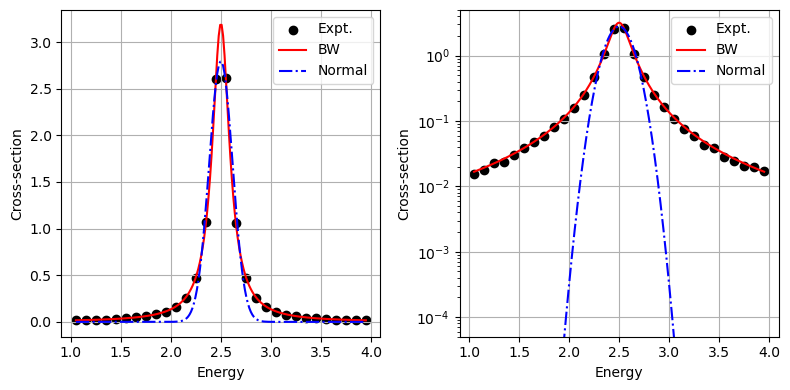

In [156]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))
N_span = 200
e_span = np.linspace(min(energy), max(energy), N_span)

for ax in axs:
    ax.scatter(energy, f, color='black', label='Expt.')
    ax.set(xlabel='Energy', ylabel='Cross-section')
    ax.plot(e_span, breit_wigner(e_span, popt), 'r-', label = 'BW')
    ax.plot(e_span, gauss_model(e_span, popt_null), 'b-.', label = 'Normal')
    ax.legend()
    ax.grid(True)

    ax1, ax2 = axs
    ax2.set_yscale('log')
    ax2.set_ylim(5E-5, 5E0)
    fig.tight_layout()

#   Nonlinear fitting

We are given the chi-squared function, which we will use for the dataset.

$$ 
\chi^2(\vec{\theta}) = 
\sum_{i=1}^N{\left(\frac{y_i - f(x_i, \vec{\theta})}{\sigma_i}\right)^2}
$$

In [158]:
'''   Here are the first 7 methods of scipy.optimize.minimize:
''' 
minimize_meth = np.array(['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'Newton-CG', 'L-BFGS-B', 'TNC'])

In [167]:
def breit_wigner_chi(x_data, y_data, sigma_vals, param_vec):
    numer = y_data - breit_wigner(x_data, param_vec)
    denom = sigma_vals
    return np.sum((numer/denom)**2)

def gauss_model_chi(x_data, y_data, sigma_vals, param_vec):
    numer = y_data - gauss_model(x_data, param_vec)
    denom = sigma_vals
    return np.sum((numer/denom)**2)

##  `optimize.minimize()`

###     Nelder-Mead Method

In [169]:
''' The function that we have above is recast, such that
    we make sure that the function takes the parameter vector only.
    
    Upon the discovery of our instructor that small values of sigma_i
    makes the number of computations extremely large, we choose that
    the denominator of the chi-squared function be equal to 1.
'''
f_sd = np.ones(f_stdev.size)
recast_func     = lambda p: breit_wigner_chi(energy, f, f_stdev, p)
recast_func_g   = lambda p: breit_wigner_chi(energy, f, f_stdev, p)
x0_param = [2.5, 0, 0]
min_result      = optimize.minimize(recast_func, x0_param, method=minimize_meth[0])
min_result_g    = optimize.minimize(recast_func, x0_param, method=minimize_meth[0])
print(f'For BW:     {min_result}')
print(f'For Normal: {min_result}')

For BW:            message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 81.41789693562943
             x: [ 2.500e+00 -2.062e-01  3.439e-02]
           nit: 231
          nfev: 419
 final_simplex: (array([[ 2.500e+00, -2.062e-01,  3.439e-02],
                       [ 2.500e+00, -2.062e-01,  3.439e-02],
                       [ 2.500e+00, -2.062e-01,  3.439e-02],
                       [ 2.500e+00, -2.062e-01,  3.439e-02]]), array([ 8.142e+01,  8.142e+01,  8.142e+01,  8.142e+01]))
For Normal:        message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 81.41789693562943
             x: [ 2.500e+00 -2.062e-01  3.439e-02]
           nit: 231
          nfev: 419
 final_simplex: (array([[ 2.500e+00, -2.062e-01,  3.439e-02],
                       [ 2.500e+00, -2.062e-01,  3.439e-02],
                       [ 2.500e+00, -2.062e-01,  3.439e-02],
                       [ 2.500e+00, -2.062e-01,  3.4

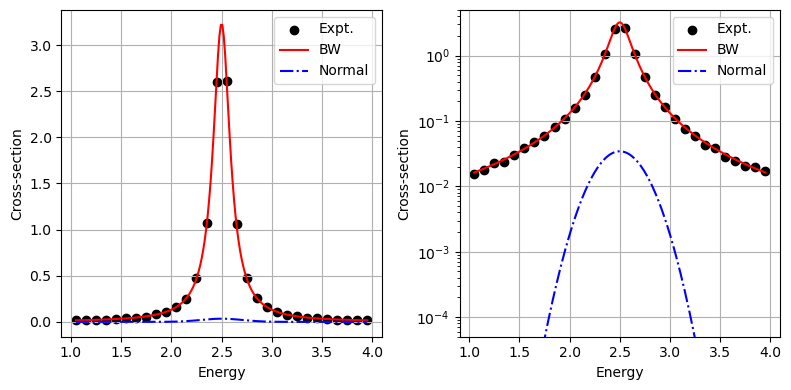

In [166]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))
e_span = np.linspace(min(energy), max(energy), 200)

for ax in axs:
    ax.scatter(energy, f, color='black', label='Expt.')
    ax.set(xlabel="Energy", ylabel="Cross-section")
    ax.plot(e_span, breit_wigner(e_span, min_result.x), "r-", label="BW")
    ax.plot(e_span, gauss_model(e_span, min_result_g.x), "b-.", label="Normal")
    ax.legend()
    ax.grid(True)

lax, rax = axs
rax.set_yscale("log")
rax.set_ylim(5e-5, 5e-0)
fig.tight_layout()

###     Powell Method

## `optimize.least_squares()`

In [174]:
f_sd = np.ones(f_stdev.size)
recast_func     = lambda p: breit_wigner_chi(energy, f, f_stdev, p)
recast_func_g   = lambda p: breit_wigner_chi(energy, f, f_stdev, p)
x0_param = [2.5, 0.1, 0.1]
min_result      = optimize.least_squares(recast_func, x0_param)
min_result_g    = optimize.least_squares(recast_func, x0_param)
print(f'For BW:     {min_result}')
print(f'For Normal: {min_result_g}')

For BW:          message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 8.142e+01]
           x: [ 2.500e+00  2.062e-01  3.438e-02]
        cost: 3314.435716640834
         jac: [[-4.162e-01 -1.025e+01 -2.163e+00]]
        grad: [-3.389e+01 -8.345e+02 -1.761e+02]
  optimality: 834.5022272537294
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00]
        nfev: 243
        njev: 233
For Normal:      message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 8.142e+01]
           x: [ 2.500e+00  2.062e-01  3.438e-02]
        cost: 3314.435716640834
         jac: [[-4.162e-01 -1.025e+01 -2.163e+00]]
        grad: [-3.389e+01 -8.345e+02 -1.761e+02]
  optimality: 834.5022272537294
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00]
        nfev: 243
        njev: 233


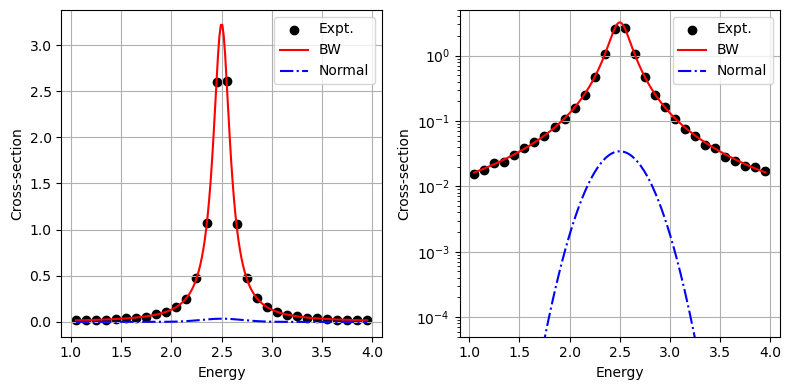

In [175]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))
e_span = np.linspace(min(energy), max(energy), 200)

for ax in axs:
    ax.scatter(energy, f, color='black', label='Expt.')
    ax.set(xlabel="Energy", ylabel="Cross-section")
    ax.plot(e_span, breit_wigner(e_span, min_result.x), "r-", label="BW")
    ax.plot(e_span, gauss_model(e_span, min_result_g.x), "b-.", label="Normal")
    ax.legend()
    ax.grid(True)

lax, rax = axs
rax.set_yscale("log")
rax.set_ylim(5e-5, 5e-0)
fig.tight_layout()

#   References and Links

[[1]](https://numpy.org/doc/stable/reference/generated/numpy.allclose.html) `np.allclose()`     
[[2]](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) `scipy.optimize.curve_fit()`      
[[3]](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) `scipy.optimize.minimize()`